## AI Research Automation System

### Overview

Research automation represents one of AI's most promising applications, offering significant potential to streamline traditionally laborious analytical work. However, raw LLM outputs often fall short of real-world decision-making requirements, necessitating customized workflows that bridge this gap.

This specification outlines a lightweight, multi-agent system built around chat models that customizes the research process to deliver actionable insights.

### Goal

Build a lightweight, multi-agent system around chat models that customizes the research process for real-world decision-making workflows.

### System Components

#### Source Selection

Users can choose any set of input sources for their research, providing flexibility in information gathering and ensuring relevance to specific domains or use cases.

#### Planning

- Users provide a research topic
- The system generates a team of AI analysts, each focusing on one sub-topic
- Human-in-the-loop refinement allows users to adjust sub-topics before research begins

#### LLM Utilization

- Each analyst conducts in-depth interviews with an expert AI using the selected sources
- Interviews follow a multi-turn conversation format to extract detailed insights (based on STORM paper methodology)
- Interview processes are captured using sub-graphs with their internal state

#### Research Process

- Experts gather information to answer analyst questions in parallel
- All interviews are conducted simultaneously through map-reduce approach
- Parallel processing enables efficient scaling of research efforts

#### Output Format

- Gathered insights from each interview are synthesized into a final report
- Customizable prompts allow for flexible output formatting
- Report structure adapts to specific use cases and decision-making requirements

In [2]:
import os
from dotenv import load_dotenv
 
load_dotenv()

OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

In [6]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0) 

In [ ]:
!pip install tavily-python wikipedia

In [ ]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"
    
# Defines an Analyst data model with structured fields. The persona property formats all analyst information into a readable string for prompts.

# Perspectives: Container for multiple analysts (used for structured LLM output)
# GenerateAnalystsState: State schema for the analyst generation workflow

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

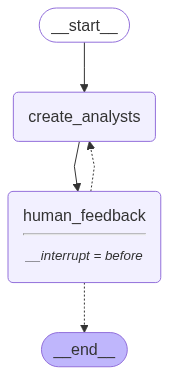

In [9]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')
        
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END

# Add nodes and edges - Analyst generation workflow

builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [10]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"

# Thread config for LangGraph state management - acts like a session ID 
# to track conversation state and enable resuming after interruptions

thread = {"configurable": {"thread_id": "1"}} 

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in various applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Liu examines the ethical implications of adopting LangGraph as an agent framework. He is concerned with issues such as data privacy, bias in AI decision-making, and the societal impact of deploying AI agents built on this framework.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Solutions Consulting
Role: Business Strategy Consultant
Description: Ms. Thompson evaluates the business benefits of implementing LangGraph, focusing on cost-effec

In [11]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [13]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03ea28-3a9c-6210-8003-0d10683e663e'}}

In [14]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Emily Carter
Affiliation: Tech Innovations Inc.
Role: AI Framework Specialist
Description: Dr. Carter focuses on the technical advantages of LangGraph, analyzing its architecture and performance metrics compared to other frameworks. She is particularly interested in how LangGraph can enhance the efficiency of AI agents in various applications.
--------------------------------------------------
Name: Mr. James Liu
Affiliation: Future AI Research Group
Role: AI Ethics Analyst
Description: Mr. Liu examines the ethical implications of adopting LangGraph as an agent framework. He is concerned with issues such as data privacy, bias in AI decision-making, and the societal impact of deploying AI agents built on this framework.
--------------------------------------------------
Name: Ms. Sarah Thompson
Affiliation: Business Solutions Consulting
Role: Business Strategy Consultant
Description: Ms. Thompson evaluates the business benefits of implementing LangGraph, focusing on cost-effec

In [15]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03ea29-259f-6cda-8005-6f5f47a74b9e'}}

In [16]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [17]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [18]:
final_state.next

()

In [19]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Jordan Lee
Affiliation: Tech Startup Incubator
Role: Startup Founder
Description: Jordan is the founder of a tech startup focused on AI solutions. They are interested in how LangGraph can streamline agent development and enhance productivity in small teams, providing insights on the practical benefits and challenges faced by startups adopting new frameworks.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: AI Research Institute
Role: AI Researcher
Description: Dr. Chen specializes in AI frameworks and their applications. Her focus is on the technical advantages of LangGraph, including its scalability and integration capabilities, and how these can lead to improved performance in AI-driven projects.
--------------------------------------------------
Name: Michael Thompson
Affiliation: Corporate Innovation Lab
Role: Corporate Strategist
Description: Michael works in a corporate innovation lab, exploring how established companies can leverage Lang

### Conduct Interview

#### Generate Question

The analyst will ask questions to the expert.

In [20]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")


In [21]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}


### Generate Answer: Parallelization

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

Specific web sites e.g., via WebBaseLoader
Indexed documents e.g., via RAG
Web search
Wikipedia search

You can try different web search tools, like Tavily.

In [22]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [23]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

Now, we create nodes to search the web and wikipedia.

We'll also create a node to answer analyst questions.

Finally, we'll create nodes to save the full interview and to write a summary ("section") of the interview.

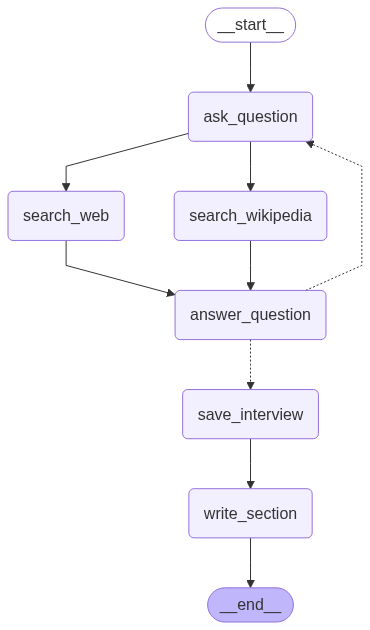

In [24]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    # Append it to state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [25]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Startup Incubator', name='Jordan Lee', role='Startup Founder', description='Jordan is the founder of a tech startup focused on AI solutions. They are interested in how LangGraph can streamline agent development and enhance productivity in small teams, providing insights on the practical benefits and challenges faced by startups adopting new frameworks.')

In [26]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Streamlining Agent Development with LangGraph: Insights for Startups

### Summary
In the rapidly evolving landscape of artificial intelligence (AI), startups are increasingly seeking frameworks that can enhance productivity and streamline the development of intelligent applications. LangGraph emerges as a powerful tool for building stateful, multi-agent applications, particularly beneficial for small teams looking to implement complex workflows. One of the most notable features of LangGraph is its explicit support for cyclical workflows, which are crucial for developing agent-like behaviors. This capability allows developers to create sophisticated agents that can iteratively refine their actions, leading to improved decision-making and adaptability in various applications, from finance to healthcare [1].

The integration of LangGraph with AI agents has shown promising results, as evidenced by its application in a FinTech startup that developed an intelligent trading assistant, enhancing traders' decision-making processes [2]. Similarly, healthcare providers have leveraged LangGraph to improve patient care and streamline operations, showcasing its versatility across different sectors [2]. The framework's ability to manage state and coordinate interactions among multiple agents allows for more efficient communication and task execution, ultimately driving greater return on investment (ROI) for organizations [2][3].

However, while LangGraph offers significant advantages, it also introduces a level of complexity that may not be justified for simpler applications. Startups must carefully evaluate their specific needs and the potential benefits of adopting such a framework [1]. The learning curve associated with mastering LangGraph can be steep, but the long-term benefits for developing advanced AI applications make it a worthwhile investment for many [1][3]. As AI applications continue to grow in sophistication, tools like LangGraph will play an increasingly vital role in helping developers create more capable and reliable systems.

1. [LangGraph: A Framework for Building Stateful Multi-Agent LLM Applications](https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03)  
2. [AI Agents in LangGraph](https://www.rapidinnovation.io/post/ai-agents-in-langgraph)  
3. [How to Think About Agent Frameworks](https://blog.langchain.dev/how-to-think-about-agent-frameworks/)  
4. [LangChain - LangGraph](https://www.langchain.com/langgraph)  

### Sources
[1] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03  
[2] https://www.rapidinnovation.io/post/ai-agents-in-langgraph  
[3] https://blog.langchain.dev/how-to-think-about-agent-frameworks/  
[4] https://www.langchain.com/langgraph  